__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Вт 10 янв 2023 12:26:49 MSK


In [2]:
# !pip install plotly ipywidgets plotly-geo

In [3]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import plotly
# import contextily as ctx
# from shapely.geometry import Polygon

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()
# pd.options.plotting.backend = 'plotly'

In [5]:
# !ls -1 data

In [6]:
# import shapely
# shapely.__version__
# '1.8.4'

In [7]:
# !pip install greppo==0.0.32
# !pip install shapely==1.8.2

In [8]:
# !pip install --upgrade pip

In [9]:
# !pip install --upgrade pygeos==0.10.2

In [10]:
# !pip freeze > requirements.txt
# !pip install -r requirements.txt

## считываем данные

In [11]:
data_file = 'data/data_flat.pkl'

In [12]:
cols = ['title','adr','latitude','longitude','priceM','dt']
df = pd.read_pickle(data_file)
# df['dt'] = pd.to_datetime( df['ts'].dt.date )
df['dt'] = df['ts'].dt.date
print(len(df))
df.sample(3)[cols]

46874


,title,adr,latitude,longitude,priceM,dt
25634,"1-комн. кв., 57 м², 1/3 этаж","Севастополь, район Гагаринский, улица Военных Строителей",44.57,33.41,4.80,2022-09-08
5026,"2-к. квартира, 50,1 м², 3/3 эт.","Севастополь, улица Коли Пищенко, 21",44.60,33.55,6.50,2022-08-29
24155,"1-к. квартира, 35,2 м², 7/9 эт.","Севастополь, улица Братьев Манганари, д. 28",44.57148,33.429186,5.28,2023-01-10


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46874 entries, 0 to 46873
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          46874 non-null  object        
 1   price          46874 non-null  int64         
 2   adr_orig       46874 non-null  object        
 3   description    46874 non-null  object        
 4   obj_name       46874 non-null  object        
 5   ts             46874 non-null  datetime64[ns]
 6   avito_page     24230 non-null  float64       
 7   place          46874 non-null  object        
 8   nrooms         46874 non-null  int64         
 9   floor          46874 non-null  int64         
 10  nfloors        46874 non-null  int64         
 11  area           46874 non-null  float64       
 12  is_studio      46874 non-null  bool          
 13  is_apartment   46874 non-null  bool          
 14  is_part        46874 non-null  bool          
 15  is_auction     4687

In [14]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )


# gdf[ gdf['title'].str.lower().str.match(r'дом 2'latitude','longitude'23,2.*') ]
df.loc[ df['adr_orig']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['adr_orig'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

In [15]:
# берём объявления с геометкой
print(len(df))
df = df[ 
    ~( df['latitude'].isnull()| df['longitude'].isnull() ) 
].reset_index(drop=True)
print(len(df))

46874
46874


In [16]:
# # берём объявления с геометкой
# print(len(df))
# df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
# print(len(df))

### ограничиваем тип объекта 

In [17]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
print(len(df))

46874
40708
40707


In [18]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
30063,"3-комн. кв., 70 м², 3/5 этаж","Севастополь, район Гагаринский, 5-й, улица Молодых Строителей, 6",44.58,33.47,10.50
836,"3-к. квартира, 75,6 м², 4/9 эт.","Севастополь, улица Токарева, 7 этап, блок-секция 3",44.58,33.50,10.21
21718,"1-к. квартира, 31 м², 7/9 эт.","Севастополь, улица Токарева, 7 этап, блок-секция 1",44.59,33.50,5.42


In [19]:
df.sample(10)[['title','adr','url']].to_dict('records') 

[{'title': '1-комн. кв., 19,3 м², 2/2 этаж',
  'adr': 'Севастополь, район Балаклавский, Балаклава, улица Калича, 12',
  'url': 'https://sevastopol.cian.ru/sale/flat/277355962/'},
 {'title': '2-комн. кв., 67,1 м², 4/10 этаж',
  'adr': 'Севастополь, район Ленинский, спуск Стрелецкий',
  'url': 'https://sevastopol.cian.ru/sale/flat/275272657/'},
 {'title': '1-комн. апарт., 18,7 м², 1/2 этаж',
  'adr': 'Севастополь, район Нахимовский, Любимовка, улица Южногородская, 36 к4',
  'url': 'https://sevastopol.cian.ru/sale/flat/277793468/'},
 {'title': '1-комн. кв., 47 м², 2/5 этаж',
  'adr': 'Севастополь, район Гагаринский, Омега, улица Челнокова, 12/3',
  'url': 'https://sevastopol.cian.ru/sale/flat/274661234/'},
 {'title': '1-к. квартира, 40\xa0м², 2/10\xa0эт.',
  'adr': 'Севастополь, улица Степаняна, 4/2',
  'url': 'https://avito.ru/2517654909'},
 {'title': '2-к. квартира, 45,2\xa0м², 3/5\xa0эт.',
  'adr': 'Севастополь,Балаклава, улица Аксютина, 18',
  'url': 'https://avito.ru/2423905786'},
 {

In [20]:
del df

In [21]:
gdf[['title','adr','priceM','geometry']].sample(100).explore()

## общая статистика

### количество предложений

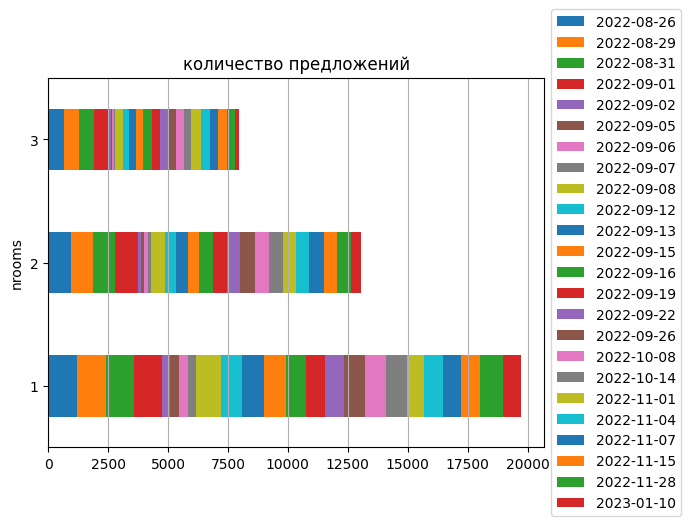

In [22]:
fig = ( # количество предложений
    gdf
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

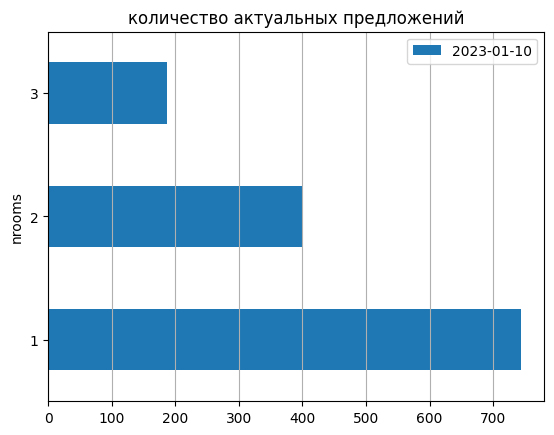

In [23]:
fig = ( # количество актуальных предложений
    gdf[ gdf['dt'] == gdf['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений') #, stacked=True )
)
fig.legend() # loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [24]:
stat = gdf.groupby(['nrooms','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
# stat

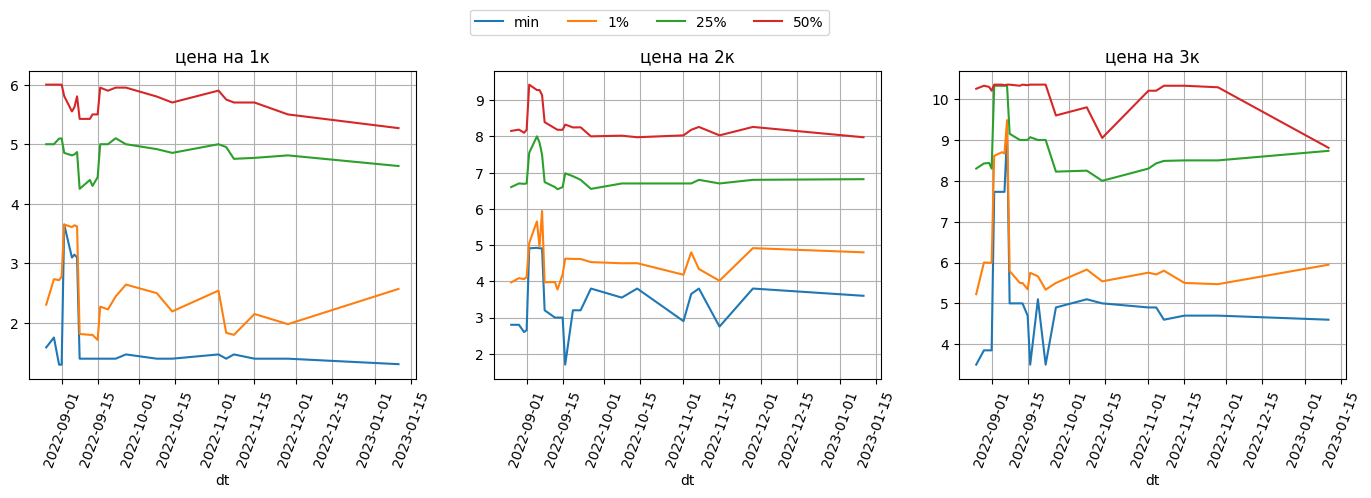

In [25]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,4), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

### гексагональная сетка и медиана актуальной цены

In [26]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()


In [27]:
# frame_all.to_file('data/frame_all.geojson', driver='GeoJSON')

In [28]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [29]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0],cell_size=6 )
print(len(grid))
grid.sample(2)

24


,hex_id,geometry
15,862d2896fffffff,"POLYGON ((33.48675 44.68010, 33.46533 44.65066, 33.49229 44.62190, 33.54065 44.62256, 33.56208 44.65198, 33.53515 44.68076, 33.48675 44.68010))"
17,862d288e7ffffff,"POLYGON ((33.72323 44.47910, 33.70180 44.44966, 33.72858 44.42080, 33.77677 44.42139, 33.79822 44.45082, 33.77146 44.47968, 33.72323 44.47910))"


In [30]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [31]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [32]:
frames.explore('area_name', legend=True)

In [33]:
# frames.to_file('data/frames.geojson', driver='GeoJSON')

In [34]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
'Севастополь, район Острякова',
# 'Севастополь, Малахов курган',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

40707
3350


In [35]:
frames.iloc[[0]]

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"


In [36]:
# новые (актуальные) предложения
# gdf_[gdf_['ts']>ts][['title','priceM','adr','geometry']].explore( legend=False)
gdf_[['title','priceM','adr','geometry']].explore( legend=False)

In [37]:
locations = ' | '.join(area_name)
locations

'Севастополь, район Острякова'

### количество предложений

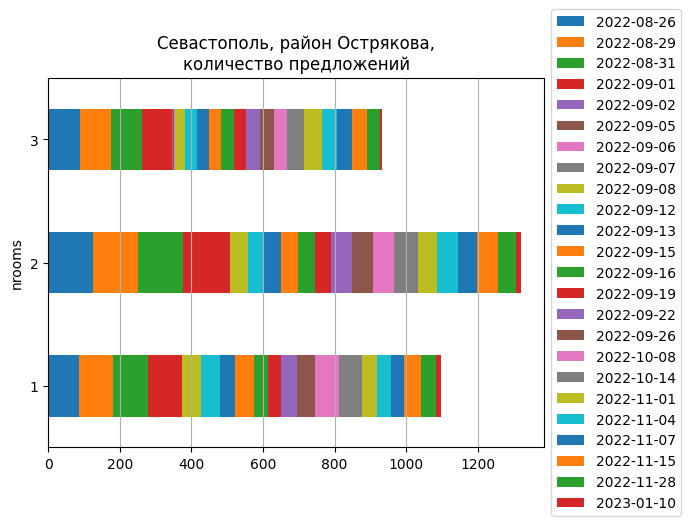

In [38]:
fig = ( # количество предложений
    gdf_.groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot.barh(legend=False,title=f'{locations},\nколичество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

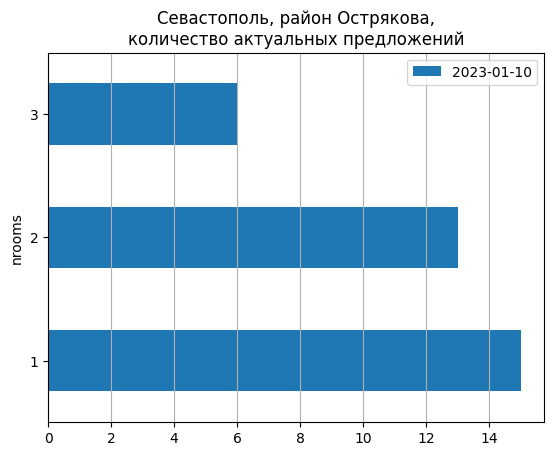

In [39]:
fig = ( # количество актуальных предложений
    gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
    .groupby(['dt','nrooms'])
    .size().reset_index()
    .pivot(index='nrooms', columns='dt', values=0)
    .plot.barh(legend=False,title=f'{locations},\nколичество актуальных предложений',stacked=True)

)
fig.legend() #loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [40]:
stat = gdf_.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])
# stat

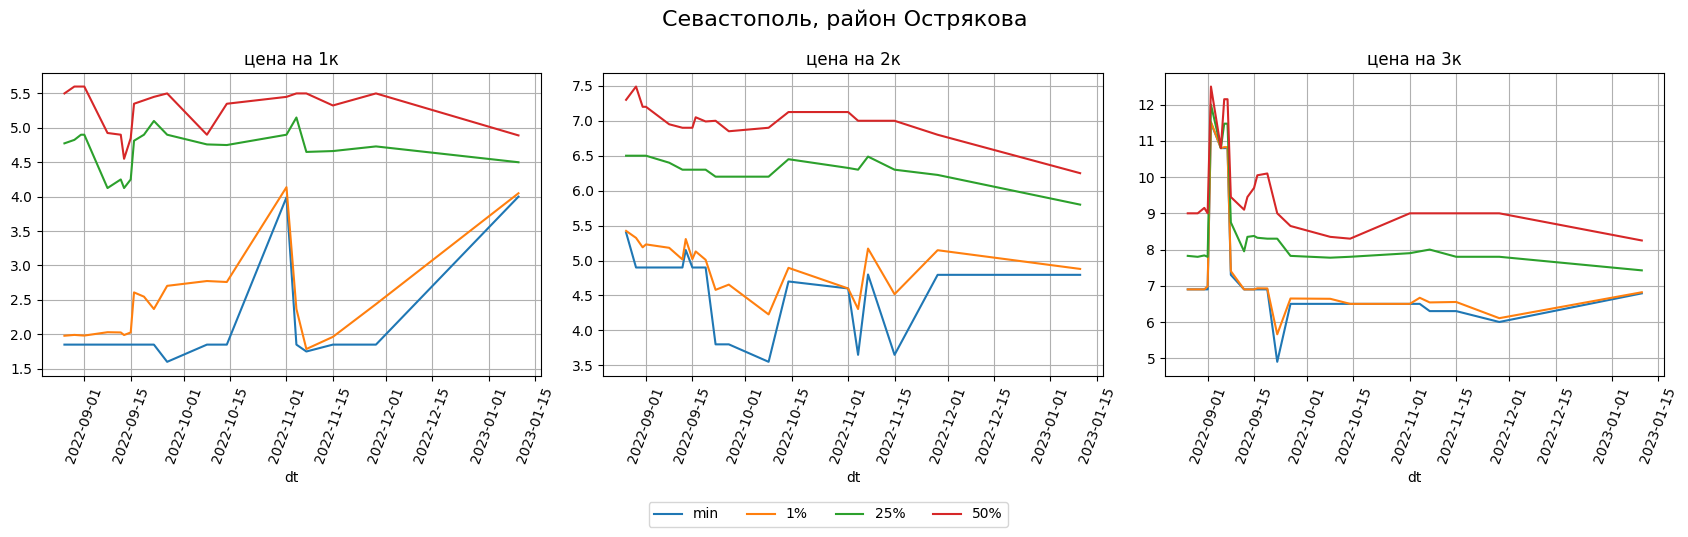

In [41]:
import matplotlib.pyplot as plt

sizes = [1,2,3,]
cols = ['min','1%','25%','50%']
fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=False )
for i,k in enumerate(sizes): 
    stat.loc[k,cols].plot(title=f'цена на {k}к', grid=True,ax=ax[i],legend=False, rot=70 )   
    
fig.suptitle(locations, fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

### гексагональная сетка и  медиана актуальной цены

In [42]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

54


,hex_id,geometry
36,892d28942cfffff,"POLYGON ((33.52400 44.56878, 33.52367 44.56699, 33.52576 44.56583, 33.52817 44.56646, 33.52849 44.56825, 33.52641 44.56941, 33.52400 44.56878))"
26,892d289425bffff,"POLYGON ((33.52752 44.56288, 33.52719 44.56109, 33.52928 44.55993, 33.53169 44.56056, 33.53201 44.56235, 33.52993 44.56351, 33.52752 44.56288))"


In [43]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)